<a href="https://colab.research.google.com/github/Sandeepreddyr12/recom-ml-Server/blob/master/eComRecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

In [2]:
!pip install faker
from faker import Faker
fake = Faker();

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.4 MB/s eta 0:00:00


In [4]:
import random


def generate_products(num_products):
    products = [{"product_id":"product_008f195jfdd5acd","name":"Nike Mens Slim-fit Long-Sleeve T-Shirt","category":"T-Shirts","brand":"Nike","avgRating":4.71,"numReviews":7,"description":"Made with chemicals safer for human health and the environment"},{"product_id":"product_10d7e1g379dg09","name":"Jerzees Long-Sleeve Heavyweight Blend T-Shirt","category":"T-Shirts","brand":"Jerzees","avgRating":4.2,"numReviews":10,"description":"Made with sustainably sourced USA grown cotton; Shoulder-to-shoulder tape; double-needle coverstitched front neck; Set-in sleeves; Rib cuffs with concealed seams; Seamless body for a wide printing area"},{"product_id":"product_2059gh3bibj0i0d","name":"Jerzees Men's Long-Sleeve T-Shirt","category":"T-Shirts","brand":"Jerzees","avgRating":4,"numReviews":12,"description":"The Jerzees long sleeve t-shirt is made with dri-power technology that wicks away moisture to keep you cool and dry throughout your day. We also included a rib collar and cuffs for added durability, and a lay-flat collar for comfort. If you are looking for a versatile shirt that you can wear throughout the transitioning seasons, then look no further."},{"product_id":"product_30c6b2hd8j398dd","name":"Decrum Mens Plain Long Sleeve T-Shirt - Comfortable Soft Fashion V Neck Full Sleeves Jersey Shirts","category":"T-Shirts","brand":"Jerzees","avgRating":3.85,"numReviews":14,"description":"Elevate your outfit with this soft long sleeve t shirt men. This full sleeves tee is the ultimate upgrade from your regular cotton t-shirt. "},
     {"product_id":"product_401ii64jd35701e","name":"Muscle Cmdr Men's Slim Fit Henley Shirt Long&Short Business Sleeve Casual 3 Metal Buton Placket Casual Stylish T-Shirt","category":"T-Shirts","brand":" Muscle Cmdr","avgRating":3.66,"numReviews":15,"description":"Slim Fit Design:Men's Muscle Slim Fit Button Henley Shirts are designed to fit snugly against your body, accentuating your muscles and creating a sleek silhouette that's perfect for any occasion. "},{"product_id":"product_50cbi7ghc4987c","name":"Hanes Mens Long Sleeve Beefy Henley Shirt","category":"T-Shirts","brand":"Jerzees","avgRating":3.46,"numReviews":13,"description":"Heavyweight cotton (Heathers are 60% cotton/40% polyester; Pebblestone is 75% cotton/25% polyester)"},{"product_id":"product_60261342h4915c2","name":"Silver Jeans Co. Mens Jace Slim Fit Bootcut Jeans","category":"Jeans","brand":"Silver Jeans Co","avgRating":4.71,"numReviews":7,"description":"Silver Jeans Co. Jace Slim Fit Bootcut Jeans - Consider Jace a modern cowboy jean. It sits below the waist and features a slim fit through the hip and thigh. Finished with an 18” bootcut leg opening that complements the slimmer silhouette while still fitting over boots"},
      {"product_id":"product_70600b3eih3b2c","name":"Levi's mens 505 Regular Fit Jeans (Also Available in Big & Tall)","category":"Jeans","brand":"Levi's","avgRating":4.2,"numReviews":10,"description":"A veritable classic, this 505 is made to have a comfortable look and style."},{"product_id":"product_80hjcfg5e81eh15","name":"Essentials Mens Straight-Fit Stretch Jean","category":"Jeans","brand":"Essentials","avgRating":4,"numReviews":12,"description":"These classic 5-pocket straight-fit jeans are crafted with a bit of stretch for additional comfort and to help maintain their shape"},{"product_id":"product_90ae3008cfijdh","name":"Buffalo David Bitton Mens Men's Driven Relaxed Denim JeansJeans","category":"Jeans","brand":"Buffalo David Bitton","avgRating":3.85,"numReviews":14,"description":"Stretch recycled denim jeans in an authentic and sanded wash blue. Features a comfortable low-rise waist with a relaxed fit at the leg. The distressed look gives these jeans an effortlessly worn-in feel. The eco-friendly logo patch in tan and red is at the back waistband. The signature maple leaf graphic is debossed at the zip-fly."},{"product_id":"product_100i28c29i11f6fd","name":"Dickies Mens Relaxed Fit Carpenter Jean","category":"Jeans","brand":"Dickies","avgRating":3.66,"numReviews":15,"description":"Relaxed work jean with traditional carpenter-style pockets and logo patch at back pockets"},{"product_id":"product_1108b4e425ggjjj6","name":"Wrangler mens Premium Performance Cowboy Cut Slim Fit Jean","category":"Jeans","brand":"Wrangler","avgRating":3.46,"numReviews":13,"description":"Designed with a functional fit in mind, these jeans are made to stack over your favorite pair of boots. Constructed with a slim fit in the waist, seat, and thigh, this jean is made for both function and comfort for long days in the saddle."},
       {"product_id":"product_120f2fia1ja7945","name":"Seiko Men's Analogue Watch with Black Dial","category":"Wrist Watches","brand":"Seiko","avgRating":4.71,"numReviews":7,"description":"Casing: Case made of stainless steel Case shape: round Case colour: silver Glass: Hardlex Clasp type: Fold over clasp with safety"},{"product_id":"product_130ha1a72cbcij7d","name":"SEIKO 5 Sport SRPJ83 Beige Dial Nylon Automatic Watch, Beige, Automatic Watch","category":"Wrist Watches","brand":"Seiko","avgRating":4.2,"numReviews":10,"description":"Seiko 5 Sports Collection Inspired by vintage field/aviator style: Automatic with manual winding capability"},{"product_id":"product_140j5g9484ea4j66","name":"Casio Men's Heavy Duty Analog Quartz Stainless Steel Strap, Silver, 42 Casual Watch ","category":"Wrist Watches","brand":"Casio","avgRating":4,"numReviews":12,"description":"The Casio range is growing with this model  MWA-100H-1AVEF. Sporting a stainless steel case with a brushed finish, it will easily withstand all the shocks of everyday life."},{"product_id":"product_150ihh9jae6afej","name":"Casio Classic Silver-Tone Stainless Steel Band Date Indicator Watch","category":"Wrist Watches","brand":"Casio","avgRating":3.85,"numReviews":14,"description":"The new MTPVD01D-7EV is a classic 50 meter water resistant stainless steel watch now updated with a white dial. This elegant 3 hand, date display timepiece is perfect for any setting."},
        {"product_id":"product_1605396i5h049bd","name":"Fossil Men's Grant Stainless Steel Quartz Chronograph Watch","category":"Wrist Watches","brand":"Fossil","avgRating":3.66,"numReviews":15,"description":"Chronograph watch featuring silver- and blue-tone case, blue sunray dial, and silver-tone Roman numeral indices"},{"product_id":"product_1709hh0g4fd625c8","name":"Fossil Men's Machine Stainless Steel Quartz Watch","category":"Wrist Watches","brand":"Fossil","avgRating":3.46,"numReviews":13,"description":"In masculine black-on-black, our industrial-inspired Machine watch will add a fresh, modern touch to your casual look. This Machine watch also features a three hand movement on a stainless steel bracelet."},{"product_id":"product_180jage4218033b","name":"adidas Mens Grand Court 2.0 Training Shoes Training Shoes","category":"Shoes","brand":"adidas","avgRating":4.71,"numReviews":7,"description":"Cloudfoam Comfort sockliner is ultra-soft and plush, with two layers of cushioning topped with soft, breathable mesh"},
         {"product_id":"product_190c5di4f691e475","name":"ziitop Men's Running Walking Shoes Fashion Sneakers Mesh Dress Shoes Business Oxfords Shoes Lightweight Casual Breathable Work Formal Shoes","category":"Shoes","brand":"ziitop","avgRating":4.2,"numReviews":10,"description":"Cloudfoam Comfort sockliner is ultra-soft and plush, with two layers of cushioning topped with soft, breathable mesh"},{"product_id":"product_200a9788da8gg19","name":"Skechers mens Summits High Range Hands Free Slip-in Shoes Work shoe","category":"Shoes","brand":"Skechers","avgRating":4,"numReviews":12,"description":"Step into easy-wearing comfort with Skechers Hands Free Slip-ins™: Summits - High Range. Along with our Exclusive Heel Pillow™ holds your foot securely in place, this vegan style features a unique pop-up Skechers Slip-ins™ molded heel panel, a mesh upper with fixed laces"},{"product_id":"product_210721hbd204ib74","name":"DLWKIPV Mens Running Shoes Tennis Cross Training Sneakers Fashion Non Slip Outdoor Walking Jogging Shoes Mesh Light Flexible Comfortable Breathable Shoes","category":"Shoes","brand":"DLWKIPV","avgRating":3.85,"numReviews":14,"description":"Design: Mesh vamp, ventilation. Sole anti-slip groove design, shock absorption and anti-slip. The inside of the shoe is wide and soft, bringing you a good comfortable experience"},{"product_id":"product_2201d4ei10i64i12","name":"ASICS Men's GT-2000 13 Running Shoes","category":"Shoes","brand":"ASICS","avgRating":3.66,"numReviews":15,"description":"At least 50% of the shoe's main upper material is made with recycled content to reduce waste and carbon emissions"},
          {"product_id":"product_230b4e65j5d86jd","name":"Mens Wearbreeze Shoes, Urban - Ultra Comfortable Shoes, Breeze Shoes for Men, Men's Mesh Dress Sneakers Business Shoes","category":"Shoes","brand":"Generic","avgRating":3.46,"numReviews":13,"description":"Cloudfoam Comfort sockliner is ultra-soft and plush, with two layers of cushioning topped with soft, breathable mesh"}]

    product_names = set()

    category_brands = {
        "T-Shirts": ["Nike", "Jerzees", "Muscle Cmdr", "US Polo", "Teamspirit", "DNMX", "rare rabbit", "Bear house", "United Colors of Benetton", "Levi's", "Tommy Hilfiger", "U.S. Polo Assn.", "FILA", "GAP", "Roadster", "Jack & Jones", "Nautica", "Mast & Harbour", "American Crew", "Aeropostale", "Adidas Originals", "Bewakoof", "Allen Solly", "Duke", "Ed Hardy", "Highlander", "H&M", "Lacoste", "Nike", "Puma", "Red Tape", "Arrow", "Peter England", "Van Heusen", "Marks and Spencer", "Louis Philippe", "Raymond", "Blackberrys", "Lee", "Spykar", "The Souled Store", "Wrangler", "Pepe Jeans", "Flying Machine", "Indian Terrain", "John Players", "Fila", "Jockey", "Vero Moda", "Calvin Klein", "Zara", "XYXX Crew", "Mufti" ],
        "Jeans": ["Silver Jeans Co", "Levi's", "Essentials", "Diesel", " Gap", "Wrangler", "Flying machine","Levi's", "Wrangler", "Lee", "Pepe Jeans", "Diesel", "Spykar", "Calvin Klein", "Mufti", "Allen Solly", "Jack & Jones", "Indian Terrain", "Flying Machine", "Numero Uno", "Lee Cooper", "Denizen", "Killer Jeans", "G-Star Raw", "Tommy Hilfiger", "BOSS"],
        "Wrist Watches": ["Seiko", "Casio", "Fossil", "sonata", "G-force", "Fossil","Titan", "Fastrack", "Casio",  "Citizen", "Timex", "Rolex", "Omega", "TAG Heuer", "Longines", "Rado", "Patek Philippe", "Breitling", "Daniel Wellington"],
        "Shoes": [ "ziitop", "redtape", "crocs","Nike", "Adidas", "Puma", "Reebok", "Skechers", "Bata", "Woodland", "Hush Puppies", "Louis Philippe", "Arrow", "Mochi", "Sparx", "Relaxo", "Liberty", "Walkaroo", "Red Chief"]
    }

    category_keywords = {
        "T-Shirts": ["cotton", "slim-fit", "comfortable", "lightweight", "stretchable", "full-sleeves", "baggy","graphic"],
        "Jeans": ["denim", "boot-cut", "straight-leg", "ripped", "high-rise" ,"Torned", "black", "blue", "slim -fit"],
        "Wrist Watches": ["stainless-steel", "leather strap", "water-resistant", "chronograph", "automatic"],
        "Shoes": ["running", "sneakers", "leather", "slip-on", "breathable", "slip-ons"]
    }

    category_nouns = {
        "T-Shirts": "t-shirt",
        "Jeans": "jeans",
        "Wrist Watches": "watch",
        "Shoes": "shoe"
    }

    for i in range(num_products):
        while True:
            category = random.choice(list(category_brands.keys()))
            brand = random.choice(category_brands[category])
            keywords = random.sample(category_keywords[category], k=2)

            # Name can include one keyword and category noun
            name = f"{brand} {keywords[0].capitalize()} {category_nouns[category].capitalize()}"

            if name not in product_names:
                product_names.add(name)
                break


        # Construct a more structured, realistic description
        description = (
            f"Experience the perfect blend of style and comfort with this {keywords[0]} and {keywords[1]} "
            f"{category_nouns[category]} from {brand}. Designed to elevate your everyday look, "
            f"it's a great choice for any occasion."
        )

        product = {
            "product_id": f"product_{i}",
            "name": name,
            "category": category,
            "brand": brand,
            "avgRating": round(random.uniform(3.2, 4.9), 2),
            "numReviews": random.randint(10, 200),
            "description": description
        }

        products.append(product)

    return products
products = generate_products(30)
display(products)
display(products)

[{'product_id': 'product_008f195jfdd5acd',
  'name': 'Nike Mens Slim-fit Long-Sleeve T-Shirt',
  'category': 'T-Shirts',
  'brand': 'Nike',
  'avgRating': 4.71,
  'numReviews': 7,
  'description': 'Made with chemicals safer for human health and the environment'},
 {'product_id': 'product_10d7e1g379dg09',
  'name': 'Jerzees Long-Sleeve Heavyweight Blend T-Shirt',
  'category': 'T-Shirts',
  'brand': 'Jerzees',
  'avgRating': 4.2,
  'numReviews': 10,
  'description': 'Made with sustainably sourced USA grown cotton; Shoulder-to-shoulder tape; double-needle coverstitched front neck; Set-in sleeves; Rib cuffs with concealed seams; Seamless body for a wide printing area'},
 {'product_id': 'product_2059gh3bibj0i0d',
  'name': "Jerzees Men's Long-Sleeve T-Shirt",
  'category': 'T-Shirts',
  'brand': 'Jerzees',
  'avgRating': 4,
  'numReviews': 12,
  'description': 'The Jerzees long sleeve t-shirt is made with dri-power technology that wicks away moisture to keep you cool and dry throughout you

[{'product_id': 'product_008f195jfdd5acd',
  'name': 'Nike Mens Slim-fit Long-Sleeve T-Shirt',
  'category': 'T-Shirts',
  'brand': 'Nike',
  'avgRating': 4.71,
  'numReviews': 7,
  'description': 'Made with chemicals safer for human health and the environment'},
 {'product_id': 'product_10d7e1g379dg09',
  'name': 'Jerzees Long-Sleeve Heavyweight Blend T-Shirt',
  'category': 'T-Shirts',
  'brand': 'Jerzees',
  'avgRating': 4.2,
  'numReviews': 10,
  'description': 'Made with sustainably sourced USA grown cotton; Shoulder-to-shoulder tape; double-needle coverstitched front neck; Set-in sleeves; Rib cuffs with concealed seams; Seamless body for a wide printing area'},
 {'product_id': 'product_2059gh3bibj0i0d',
  'name': "Jerzees Men's Long-Sleeve T-Shirt",
  'category': 'T-Shirts',
  'brand': 'Jerzees',
  'avgRating': 4,
  'numReviews': 12,
  'description': 'The Jerzees long sleeve t-shirt is made with dri-power technology that wicks away moisture to keep you cool and dry throughout you

In [5]:
import random
from datetime import datetime, timedelta

def generate_users(num_users):
    users = []
    for i in range(num_users):
        user = {
            "user_id": f"user_{i}",
            "createdAt": datetime.now() - timedelta(days=random.randint(0, 730))
        }
        users.append(user)
    return users

def generate_user_interactions(users, products, num_interactions):
    interactions = []
    interaction_types = ['view', 'add_to_cart', 'purchase']
    for _ in range(num_interactions):
        user = random.choice(users)
        product = random.choice(products)
        interaction_type = random.choices(
            interaction_types,
            weights=[0.7, 0.2, 0.1],  # more views, fewer purchases
            k=1
          )[0]

        value = 0
        if interaction_type == 'add_to_cart' or interaction_type == 'purchase':
            value = random.randint(1, 3)


# in real-world e-commerce platforms, reviews are usually skewed toward higher ratings, especially:

# 5 stars and 4 stars are far more common.

# 1 and 2 stars are relatively rare (unless the product is truly bad).

# This is due to positivity bias, satisfied customers being more likely to leave a review, or the seller prompting only happy customers to review.

        review_stars = 0
        if interaction_type == 'purchase' and random.random() < 0.6:  # 60% chance of review
                 review_stars = random.choices(
                      [5, 4, 3, 2, 1],
                weights=[40, 30, 13, 7, 10],  # You can tweak these
                     k=1
                      )[0]



                      # for mor comlpexity
#  You can vary weights per product type (e.g., electronics may get lower avg reviews than clothing).

# Or per user profile — experienced users may rate more harshly

        interaction = {
            "userId": user["user_id"],
            "productId": product["product_id"],  # Use the new product_id
            "interactionType": interaction_type,
            "value": value,
            "reviewStars": review_stars,
            "category": product["category"],
            "createdAt": datetime.now() - timedelta(minutes=random.randint(0, 525600))
        }
        interactions.append(interaction)
    return interactions

# Generate the data
num_users = 1000
num_products = 500
num_interactions = 50000

products = generate_products(num_products)
users = generate_users(num_users)
user_interactions = generate_user_interactions(users, products, num_interactions)

# Display a sample of the generated data
print("Sample Products:")
display(products[:5])
print("\nSample Users:")
display(users[:5])
print("\nSample User Interactions:")
display(user_interactions[:5])

Sample Products:


[{'product_id': 'product_008f195jfdd5acd',
  'name': 'Nike Mens Slim-fit Long-Sleeve T-Shirt',
  'category': 'T-Shirts',
  'brand': 'Nike',
  'avgRating': 4.71,
  'numReviews': 7,
  'description': 'Made with chemicals safer for human health and the environment'},
 {'product_id': 'product_10d7e1g379dg09',
  'name': 'Jerzees Long-Sleeve Heavyweight Blend T-Shirt',
  'category': 'T-Shirts',
  'brand': 'Jerzees',
  'avgRating': 4.2,
  'numReviews': 10,
  'description': 'Made with sustainably sourced USA grown cotton; Shoulder-to-shoulder tape; double-needle coverstitched front neck; Set-in sleeves; Rib cuffs with concealed seams; Seamless body for a wide printing area'},
 {'product_id': 'product_2059gh3bibj0i0d',
  'name': "Jerzees Men's Long-Sleeve T-Shirt",
  'category': 'T-Shirts',
  'brand': 'Jerzees',
  'avgRating': 4,
  'numReviews': 12,
  'description': 'The Jerzees long sleeve t-shirt is made with dri-power technology that wicks away moisture to keep you cool and dry throughout you


Sample Users:


[{'user_id': 'user_0',
  'createdAt': datetime.datetime(2025, 2, 15, 2, 53, 57, 517256)},
 {'user_id': 'user_1',
  'createdAt': datetime.datetime(2024, 9, 29, 2, 53, 57, 517275)},
 {'user_id': 'user_2',
  'createdAt': datetime.datetime(2025, 6, 11, 2, 53, 57, 517278)},
 {'user_id': 'user_3',
  'createdAt': datetime.datetime(2024, 8, 11, 2, 53, 57, 517281)},
 {'user_id': 'user_4',
  'createdAt': datetime.datetime(2024, 6, 23, 2, 53, 57, 517283)}]


Sample User Interactions:


[{'userId': 'user_260',
  'productId': 'product_498',
  'interactionType': 'view',
  'value': 0,
  'reviewStars': 0,
  'category': 'T-Shirts',
  'createdAt': datetime.datetime(2025, 2, 6, 8, 13, 57, 519387)},
 {'userId': 'user_167',
  'productId': 'product_377',
  'interactionType': 'view',
  'value': 0,
  'reviewStars': 0,
  'category': 'T-Shirts',
  'createdAt': datetime.datetime(2025, 4, 16, 14, 41, 57, 519401)},
 {'userId': 'user_634',
  'productId': 'product_205',
  'interactionType': 'view',
  'value': 0,
  'reviewStars': 0,
  'category': 'T-Shirts',
  'createdAt': datetime.datetime(2025, 1, 1, 9, 16, 57, 519409)},
 {'userId': 'user_372',
  'productId': 'product_109',
  'interactionType': 'add_to_cart',
  'value': 2,
  'reviewStars': 0,
  'category': 'Wrist Watches',
  'createdAt': datetime.datetime(2025, 3, 16, 4, 42, 57, 519418)},
 {'userId': 'user_640',
  'productId': 'product_111',
  'interactionType': 'view',
  'value': 0,
  'reviewStars': 0,
  'category': 'T-Shirts',
  'cre

In [6]:

import pandas as pd


Now you can run the following cell to import the necessary libraries.

In [7]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in your Google Drive to store the data
drive_folder = '/content/drive/MyDrive/e-commerce-data'
os.makedirs(drive_folder, exist_ok=True)


# Convert to pandas DataFrames
products_df = pd.DataFrame(products)
users_df = pd.DataFrame(users)
interactions_df = pd.DataFrame(user_interactions)

# Save to CSV files in the new folder
products_df.to_csv(os.path.join(drive_folder, "products.csv"), index=False)
users_df.to_csv(os.path.join(drive_folder, "users.csv"), index=False)
interactions_df.to_csv(os.path.join(drive_folder, "interactions.csv"), index=False)

print(f"Data saved to {drive_folder}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data saved to /content/drive/MyDrive/e-commerce-data


In [ ]:
# Load the data
products_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/products.csv')
users_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/users.csv')
interactions_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/interactions.csv')

# Display basic info
display("Products shape:", products_df.head())
# print("Users shape:", users_df.head())
# print("Users shape:", users_df.shape)
# print("Interactions shape:", interactions_df.shape)

'Products shape:'

,product_id,name,category,brand,avgRating,numReviews,description
0,product_008f195jfdd5acd,Nike Mens Slim-fit Long-Sleeve T-Shirt,T-Shirts,Nike,4.71,7,Made with chemicals safer for human health and...
1,product_10d7e1g379dg09,Jerzees Long-Sleeve Heavyweight Blend T-Shirt,T-Shirts,Jerzees,4.20,10,Made with sustainably sourced USA grown cotton...
2,product_2059gh3bibj0i0d,Jerzees Men's Long-Sleeve T-Shirt,T-Shirts,Jerzees,4.00,12,The Jerzees long sleeve t-shirt is made with d...
3,product_30c6b2hd8j398dd,Decrum Mens Plain Long Sleeve T-Shirt - Comfor...,T-Shirts,Jerzees,3.85,14,Elevate your outfit with this soft long sleeve...
4,product_401ii64jd35701e,Muscle Cmdr Men's Slim Fit Henley Shirt Long&S...,T-Shirts,Muscle Cmdr,3.66,15,Slim Fit Design:Men's Muscle Slim Fit Button H...


# Task
Using the data from "/content/interactions.csv", "/content/products.csv", and "/content/users.csv", build and evaluate a hybrid recommendation system that combines collaborative filtering, content-based filtering, and popularity-based filtering. The system should be able to handle cold-start users. Save the trained models and provide a function for real-time recommendations. Finally, visualize the distribution of interaction types and implicit ratings.

## Setup and data loading

### Subtask:
Retry: Install necessary libraries and load the `products`, `users`, and `interactions` datasets from the specified file paths.


**Reasoning**:
The previous attempt to install the required libraries and import them failed due to a numpy version conflict. I will now correct the installation command to specify a compatible numpy version, then proceed with importing the necessary modules and loading the data as requested.



In [1]:
!pip install scikit-surprise pandas "numpy<2.0" scikit-learn scipy matplotlib seaborn

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, LabelEncoder
from surprise import Dataset, Reader, SVD, NMF, KNNBasic
from surprise.model_selection import train_test_split, cross_validate
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the data
products_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/products.csv')
users_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/users.csv')
interactions_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/interactions.csv')

# Display basic info
print("Products shape:", products_df.shape)
print("Users shape:", users_df.shape)
print("Interactions shape:", interactions_df.shape)

Products shape: (524, 7)
Users shape: (1000, 2)
Interactions shape: (50000, 7)


In [2]:
# Filter interactions for user_0 and user_1
user_0_interactions = interactions_df[interactions_df['userId'] == 'user_0']
user_1_interactions = interactions_df[interactions_df['userId'] == 'user_1']

# Find common products
common_products = pd.merge(user_0_interactions, user_1_interactions, on='productId', suffixes=('_user0', '_user1'))

# Add a column to indicate matched products
common_products['matched_interaction'] = True

print("User 0 Interactions:")
display(user_0_interactions)

print("\nUser 1 Interactions:")
display(user_1_interactions)

print("\nCommon Products between User 0 and User 1:")
display(common_products)

User 0 Interactions:


,userId,productId,interactionType,value,reviewStars,category,createdAt
1065,user_0,product_358,purchase,3,5,Shoes,2025-02-23 16:45:57.528445
1759,user_0,product_393,view,0,0,Shoes,2024-09-22 02:45:57.532323
3046,user_0,product_204,add_to_cart,3,0,T-Shirts,2025-06-11 22:20:57.539913
3638,user_0,product_418,view,0,0,Jeans,2025-03-12 06:54:57.543243
5363,user_0,product_395,view,0,0,T-Shirts,2025-04-22 01:08:57.552668
6210,user_0,product_150,view,0,0,Jeans,2024-09-30 11:01:57.557565
8076,user_0,product_142,view,0,0,T-Shirts,2025-04-08 02:21:57.568887
10309,user_0,product_80hjcfg5e81eh15,view,0,0,Jeans,2024-10-07 19:15:57.581258
10877,user_0,product_473,purchase,2,4,T-Shirts,2025-05-14 23:22:57.584651
14578,user_0,product_52,view,0,0,T-Shirts,2024-12-23 08:49:57.605587



User 1 Interactions:


,userId,productId,interactionType,value,reviewStars,category,createdAt
295,user_1,product_140j5g9484ea4j66,add_to_cart,3,0,Wrist Watches,2025-05-23 13:42:57.522778
1168,user_1,product_88,add_to_cart,1,0,Wrist Watches,2025-05-04 03:05:57.529044
1588,user_1,product_302,view,0,0,T-Shirts,2025-04-23 19:53:57.531393
1908,user_1,product_377,add_to_cart,3,0,T-Shirts,2024-12-28 06:28:57.533211
3010,user_1,product_33,view,0,0,T-Shirts,2025-06-19 10:25:57.539719
...,...,...,...,...,...,...,...
44591,user_1,product_78,view,0,0,Wrist Watches,2025-04-29 06:18:57.790525
44751,user_1,product_92,view,0,0,Shoes,2024-10-05 19:55:57.791408
47466,user_1,product_252,view,0,0,Wrist Watches,2024-08-13 18:13:57.806832
47893,user_1,product_390,view,0,0,Shoes,2025-04-23 12:15:57.809264



Common Products between User 0 and User 1:


,userId_user0,productId,interactionType_user0,value_user0,reviewStars_user0,category_user0,createdAt_user0,userId_user1,interactionType_user1,value_user1,reviewStars_user1,category_user1,createdAt_user1,matched_interaction
0,user_0,product_150,view,0,0,Jeans,2024-09-30 11:01:57.557565,user_1,view,0,0,Jeans,2025-04-05 05:11:57.595632,True
1,user_0,product_139,add_to_cart,3,0,Wrist Watches,2025-05-08 12:24:57.650471,user_1,add_to_cart,3,0,Wrist Watches,2024-12-27 02:56:57.675292,True
2,user_0,product_459,view,0,0,T-Shirts,2025-03-11 14:03:57.675141,user_1,view,0,0,T-Shirts,2025-06-02 09:28:57.544511,True
3,user_0,product_118,add_to_cart,3,0,Jeans,2025-01-13 08:04:57.691159,user_1,view,0,0,Jeans,2024-11-07 16:47:57.712229,True
4,user_0,product_252,add_to_cart,2,0,Wrist Watches,2024-09-07 22:45:57.701453,user_1,view,0,0,Wrist Watches,2024-08-13 18:13:57.806832,True


## Detailed data analysis

### Subtask:
Analyze user interaction patterns more deeply, analyze product features, identify data sparsity levels, and analyze the distribution of implicit ratings.


**Reasoning**:
I need to analyze user interaction patterns, product features, data sparsity, and implicit rating distribution as per the instructions. I will calculate interactions per user, analyze interaction types, examine product categories and brands, compute interactions per product, and analyze review star distribution.



In [3]:
# 1. Calculate and print the total number of interactions per user
user_interaction_counts = interactions_df.groupby('userId').size().sort_values(ascending=False)
print("Total number of interactions per user:")
display(user_interaction_counts.head())
display(user_interaction_counts.describe())

# 2. Analyze the unique values and frequency of different interaction types
print("\nFrequency of different interaction types:")
display(interactions_df['interactionType'].value_counts())

# 3. Examine the distribution of product categories and brands
print("\nDistribution of product categories:")
display(products_df['category'].value_counts())
print("\nDistribution of product brands (Top 10):")
display(products_df['brand'].value_counts().head(10))

# 4. Compute and display the average number of interactions per product
product_interaction_counts = interactions_df.groupby('productId').size()
print("\nAverage number of interactions per product:")
display(product_interaction_counts.mean())
print("\nDistribution of interactions per product:")
display(product_interaction_counts.describe())

# 5. Analyze the distribution of reviewStars
print("\nDistribution of reviewStars:")
display(interactions_df['reviewStars'].value_counts())

Total number of interactions per user:


,0
userId,
user_188,76
user_986,74
user_345,74
user_419,70
user_310,70


,0
count,1000.000000
mean,50.000000
std,7.070926
min,28.000000
25%,45.000000
50%,50.000000
75%,54.000000
max,76.000000



Frequency of different interaction types:


,count
interactionType,
view,34975
add_to_cart,10034
purchase,4991



Distribution of product categories:


,count
category,
T-Shirts,194
Jeans,145
Shoes,104
Wrist Watches,81



Distribution of product brands (Top 10):


,count
brand,
Wrangler,14
Puma,12
Levi's,12
Jack & Jones,12
Nike,10
Flying Machine,10
Calvin Klein,10
Indian Terrain,10
Pepe Jeans,9



Average number of interactions per product:


95.41984732824427


Distribution of interactions per product:


,0
count,524.000000
mean,95.419847
std,9.526418
min,68.000000
25%,89.000000
50%,96.000000
75%,102.000000
max,119.000000



Distribution of reviewStars:


,count
reviewStars,
0,46979
5,1232
4,893
3,377
1,309
2,210


**Reasoning**:
The previous command failed because `interactions_df` was not defined in the current environment. I need to reload the dataframes before proceeding with the analysis.



## Data preprocessing and feature engineering

### Subtask:
Convert `createdAt` columns to datetime objects and create `implicit_rating` and `content_features` columns.


**Reasoning**:
Convert 'createdAt' columns to datetime objects, calculate interaction weights and implicit ratings, and create the 'content_features' column in preparation for the next steps of the recommendation system.



In [4]:
# Convert datetime strings to datetime objects
users_df['createdAt'] = pd.to_datetime(users_df['createdAt'])
interactions_df['createdAt'] = pd.to_datetime(interactions_df['createdAt'])

# Create interaction weights based on interaction type
interaction_weights = {
    'view': 1,
    'add_to_cart': 2,
    'purchase': 3,
}

# Add weight column
interactions_df['weight'] = interactions_df.apply(
    lambda x: 3 if x['reviewStars'] > 0 else interaction_weights.get(x['interactionType'], 1),
    axis=1
)



def calculate_implicit_rating(x):
    review = x['reviewStars'] if x['reviewStars'] not in [0, np.nan] else 3.5
    review_adjustment = review - 3.0  # reviews below 3 subtract, above add

    if(review == 1):
       review_adjustment -= 2.0  # Extra penalty for 1-star reviews and also we need to filter while recomeding

    return x['weight'] + review_adjustment

interactions_df['implicit_rating'] = interactions_df.apply(calculate_implicit_rating, axis=1)





# Normalize implicit ratings to 1-5 scale
interactions_df['implicit_rating'] = 1 + (interactions_df['implicit_rating'] - interactions_df['implicit_rating'].min()) * 4 / (
    interactions_df['implicit_rating'].max() - interactions_df['implicit_rating'].min()
)

display(interactions_df.tail(10))

print("Interaction statistics:")
display(interactions_df.groupby('interactionType').size())
print("\nImplicit rating distribution:")
display(interactions_df['implicit_rating'].describe())

# Create product features for content-based filtering
# Combine text features
products_df['content_features'] = (
    products_df['name'].fillna('') + ' ' +
    products_df['category'].fillna('') + ' ' +
    products_df['brand'].fillna('') + ' ' +
    products_df['description'].fillna('')
)

print("\nProducts Sample with content_features:")
display(products_df.head())
display(products_df["content_features"])

,userId,productId,interactionType,value,reviewStars,category,createdAt,weight,implicit_rating
49990,user_915,product_269,view,0,0,Jeans,2024-12-19 21:31:57.821186,1,2.666667
49991,user_99,product_497,add_to_cart,2,0,Jeans,2024-10-17 18:20:57.821191,2,3.333333
49992,user_723,product_461,view,0,0,T-Shirts,2025-04-08 04:10:57.821195,1,2.666667
49993,user_795,product_11,view,0,0,Shoes,2025-06-19 00:47:57.821201,1,2.666667
49994,user_980,product_19,view,0,0,Shoes,2024-11-27 21:53:57.821206,1,2.666667
49995,user_6,product_293,add_to_cart,2,0,Jeans,2025-03-10 00:40:57.821211,2,3.333333
49996,user_635,product_137,purchase,2,2,Shoes,2025-07-29 07:13:57.821218,3,3.000000
49997,user_201,product_160,view,0,0,Wrist Watches,2025-06-06 13:17:57.821223,1,2.666667
49998,user_99,product_148,view,0,0,Wrist Watches,2025-02-02 19:09:57.821227,1,2.666667
49999,user_558,product_228,add_to_cart,1,0,Jeans,2024-11-25 12:46:57.821232,2,3.333333


Interaction statistics:


,0
interactionType,
add_to_cart,10034
purchase,4991
view,34975



Implicit rating distribution:


,implicit_rating
count,50000.000000
mean,2.938887
std,0.542285
min,1.000000
25%,2.666667
50%,2.666667
75%,3.333333
max,5.000000



Products Sample with content_features:


,product_id,name,category,brand,avgRating,numReviews,description,content_features
0,product_008f195jfdd5acd,Nike Mens Slim-fit Long-Sleeve T-Shirt,T-Shirts,Nike,4.71,7,Made with chemicals safer for human health and...,Nike Mens Slim-fit Long-Sleeve T-Shirt T-Shirt...
1,product_10d7e1g379dg09,Jerzees Long-Sleeve Heavyweight Blend T-Shirt,T-Shirts,Jerzees,4.20,10,Made with sustainably sourced USA grown cotton...,Jerzees Long-Sleeve Heavyweight Blend T-Shirt ...
2,product_2059gh3bibj0i0d,Jerzees Men's Long-Sleeve T-Shirt,T-Shirts,Jerzees,4.00,12,The Jerzees long sleeve t-shirt is made with d...,Jerzees Men's Long-Sleeve T-Shirt T-Shirts Jer...
3,product_30c6b2hd8j398dd,Decrum Mens Plain Long Sleeve T-Shirt - Comfor...,T-Shirts,Jerzees,3.85,14,Elevate your outfit with this soft long sleeve...,Decrum Mens Plain Long Sleeve T-Shirt - Comfor...
4,product_401ii64jd35701e,Muscle Cmdr Men's Slim Fit Henley Shirt Long&S...,T-Shirts,Muscle Cmdr,3.66,15,Slim Fit Design:Men's Muscle Slim Fit Button H...,Muscle Cmdr Men's Slim Fit Henley Shirt Long&S...


,content_features
0,Nike Mens Slim-fit Long-Sleeve T-Shirt T-Shirt...
1,Jerzees Long-Sleeve Heavyweight Blend T-Shirt ...
2,Jerzees Men's Long-Sleeve T-Shirt T-Shirts Jer...
3,Decrum Mens Plain Long Sleeve T-Shirt - Comfor...
4,Muscle Cmdr Men's Slim Fit Henley Shirt Long&S...
...,...
519,Lee Cooper Straight-leg Jeans Jeans Lee Cooper...
520,Marks and Spencer Comfortable T-shirt T-Shirts...
521,G-Star Raw Torned Jeans Jeans G-Star Raw Exper...
522,Van Heusen Cotton T-shirt T-Shirts Van Heusen ...


## Enhance data representation

### Subtask:
Engineer additional features for users and products, and incorporate temporal features.


**Reasoning**:
I will now engineer additional features for users and products, and incorporate temporal features into the interactions DataFrame by calculating aggregated interaction statistics for users and products, creating account age features for users, and adding temporal features to interactions, then merge these features and display the updated interactions DataFrame.



In [5]:
# Reload dataframes to ensure all original columns are present
products_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/products.csv')
users_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/users.csv')
interactions_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/interactions.csv')

# Convert datetime strings to datetime objects
users_df['createdAt'] = pd.to_datetime(users_df['createdAt'])
interactions_df['createdAt'] = pd.to_datetime(interactions_df['createdAt'])

# Re-calculate interaction weights and implicit ratings (as this cell might be run independently)
interaction_weights = {
    'view': 1,
    'add_to_cart': 2,
    'purchase': 3,
}

interactions_df['weight'] = interactions_df.apply(
    lambda x: 3 if x['reviewStars'] > 0 else interaction_weights.get(x['interactionType'], 1),
    axis=1
)

def calculate_implicit_rating(x):
    review = x['reviewStars'] if x['reviewStars'] not in [0, np.nan] else 3.5
    review_adjustment = review - 3.0  # reviews below 3 subtract, above add

    if(review == 1):
       review_adjustment -= 2.0  # Extra penalty for 1-star reviews and also we need to filter while recomeding

    return x['weight'] + review_adjustment

interactions_df['implicit_rating'] = interactions_df.apply(calculate_implicit_rating, axis=1)

# Normalize implicit ratings to 1-5 scale
interactions_df['implicit_rating'] = 1 + (interactions_df['implicit_rating'] - interactions_df['implicit_rating'].min()) * 4 / (
    interactions_df['implicit_rating'].max() - interactions_df['implicit_rating'].min()
)

# Calculate product popularity scores (regenerated here)
# Add a time decay factor to interactions - giving more weight to recent interactions
# Using a simple exponential decay: weight = exp(-decay_rate * time_since_interaction_days)
# We need the 'time_since_interaction_days' column which is created later in this cell.
# For now, calculate the base interaction count, avg rating, and purchase count
product_popularity = interactions_df.groupby('productId').agg({
    'userId': 'count',  # Number of interactions
    'implicit_rating': 'mean',  # Average rating
    'interactionType': lambda x: (x == 'purchase').sum()  # Number of purchases
}).rename(columns={
    'userId': 'interaction_count',
    'implicit_rating': 'avg_rating',
    'interactionType': 'purchase_count'
})

# Calculate popularity score based on these initial counts
max_interaction = product_popularity['interaction_count'].max()
max_purchase = product_popularity['purchase_count'].max()

product_popularity['popularity_score'] = (
    0.3 * (product_popularity['interaction_count'] / max_interaction if max_interaction > 0 else 0) +
    0.3 * (product_popularity['avg_rating'] / 5.0) +
    0.2 * (product_popularity['purchase_count'] / max_purchase if max_purchase > 0 else 0)
)

# Merge with product info to get 'name', 'avgRating', 'numReviews'
product_popularity = product_popularity.merge(
    products_df[['product_id', 'name', 'avgRating', 'numReviews']],
    left_index=True, # Merge on index of product_popularity (which is productId)
    right_on='product_id',
    how='left'
)

# Re-calculate popularity score including numReviews
max_reviews = product_popularity['numReviews'].max()
product_popularity['popularity_score'] = (
    0.3 * (product_popularity['interaction_count'] / max_interaction if max_interaction > 0 else 0) +
    0.3 * (product_popularity['avg_rating'] / 5.0) +
    0.2 * (product_popularity['purchase_count'] / max_purchase if max_purchase > 0 else 0) +
    0.2 * (product_popularity['numReviews'] / max_reviews if max_reviews > 0 else 0)
)


# 1. Create new features for users_df

# Calculate total number of interactions per user
user_total_interactions = interactions_df.groupby('userId').size().reset_index(name='total_interactions')
users_df = users_df.merge(user_total_interactions, left_on='user_id', right_on='userId', how='left').fillna(0)

# Calculate average implicit rating per user
user_avg_rating = interactions_df.groupby('userId')['implicit_rating'].mean().reset_index(name='avg_user_rating')
users_df = users_df.merge(user_avg_rating, left_on='user_id', right_on='userId', how='left').fillna(interactions_df['implicit_rating'].mean()) # Fill NaN with overall mean


# Calculate account age in days
users_df['account_age_days'] = (datetime.now() - users_df['createdAt']).dt.days

# 2. Create more sophisticated features for products_df

# Word embeddings (using TF-IDF as a proxy for now, as full embeddings require more setup)
# The TF-IDF matrix and product_similarity_df were already created in a previous step.
# We can use the product_similarity_df as a feature, but it's a matrix, not a column.
# For simplicity in merging, we can use the popularity score as a product feature.
# Product popularity was already calculated and merged into product_popularity df in a previous step.
# We can merge product_popularity into products_df to have a single product feature source.
products_df = products_df.merge(
    product_popularity[['product_id', 'popularity_score']],
    on='product_id',
    how='left'
).fillna(product_popularity['popularity_score'].mean()) # Fill NaN with overall mean

# One-hot encode categorical features 'category' and 'brand'
products_df = pd.get_dummies(products_df, columns=['category', 'brand'], prefix=['category', 'brand'])


# 3. Add temporal features to interactions_df

# Time since interaction occurred in days
interactions_df['time_since_interaction_days'] = (datetime.now() - interactions_df['createdAt']).dt.days

# Day of the week (0=Monday, 6=Sunday)
interactions_df['day_of_week'] = interactions_df['createdAt'].dt.dayofweek

# Hour of the day
interactions_df['hour_of_day'] = interactions_df['createdAt'].dt.hour

# 4. Merge the newly created user and product features back into the interactions_df DataFrame

# Check and convert 'productId' and 'product_id' columns to string type before merging
interactions_df['productId'] = interactions_df['productId'].astype(str)
products_df['product_id'] = products_df['product_id'].astype(str)

# Merge user features
interactions_df = interactions_df.merge(
    users_df[['user_id', 'total_interactions', 'avg_user_rating', 'account_age_days']],
    left_on='userId',
    right_on='user_id',
    how='left'
).drop('user_id', axis=1) # Drop the duplicate user_id column from users_df after merging


# Merge product features (using product_id as the key)
# We need to merge the one-hot encoded product features and popularity score
interactions_df = interactions_df.merge(
    products_df.drop(['name', 'description', 'avgRating', 'numReviews'], axis=1, errors='ignore'), # Dropped content_features
    left_on='productId',
    right_on='product_id',
    how='left'
).drop('product_id', axis=1)


# 5. Display the first few rows of the updated interactions_df DataFrame
print("\nUpdated Interactions DataFrame with new features:")
display(interactions_df.head())

print("\nImplicit rating distribution:")
display(interactions_df['implicit_rating'].describe())


Updated Interactions DataFrame with new features:


,userId,productId,interactionType,value,reviewStars,category,createdAt,weight,implicit_rating,time_since_interaction_days,...,brand_Woodland,brand_Wrangler,brand_XYXX Crew,brand_Zara,brand_adidas,brand_crocs,brand_rare rabbit,brand_redtape,brand_sonata,brand_ziitop
0,user_260,product_498,view,0,0,T-Shirts,2025-02-06 08:13:57.519387,1,2.666667,182,...,False,False,False,False,False,False,False,False,False,False
1,user_167,product_377,view,0,0,T-Shirts,2025-04-16 14:41:57.519401,1,2.666667,112,...,False,False,False,False,False,False,False,False,False,False
2,user_634,product_205,view,0,0,T-Shirts,2025-01-01 09:16:57.519409,1,2.666667,218,...,False,False,False,False,False,False,False,False,False,False
3,user_372,product_109,add_to_cart,2,0,Wrist Watches,2025-03-16 04:42:57.519418,2,3.333333,144,...,False,False,False,False,False,False,False,False,False,False
4,user_640,product_111,view,0,0,T-Shirts,2024-09-12 14:11:57.519425,1,2.666667,328,...,False,False,False,False,False,False,True,False,False,False



Implicit rating distribution:


,implicit_rating
count,50000.000000
mean,2.938887
std,0.542285
min,1.000000
25%,2.666667
50%,2.666667
75%,3.333333
max,5.000000


## Evaluation and visualization

### Subtask:
Visualize the distribution of interaction types and implicit ratings.


**Reasoning**:
Visualize the distribution of interaction types and implicit ratings as requested in the subtask instructions.



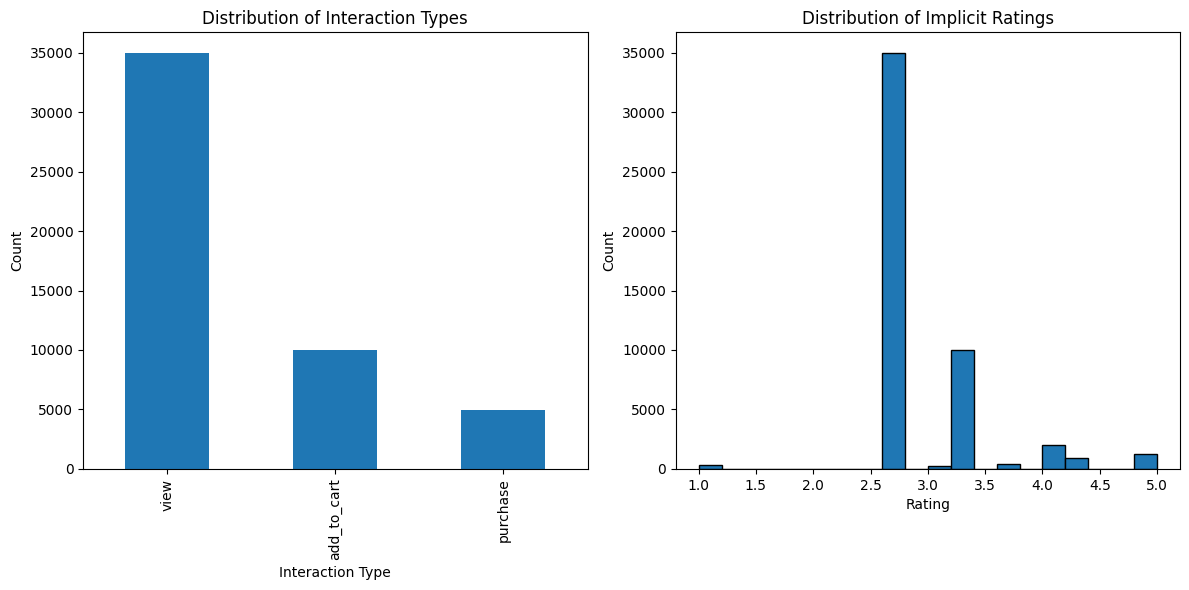

In [6]:
# Visualize interaction distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
interactions_df['interactionType'].value_counts().plot(kind='bar')
plt.title('Distribution of Interaction Types')
plt.xlabel('Interaction Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(interactions_df['implicit_rating'], bins=20, edgecolor='black')
plt.title('Distribution of Implicit Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Collaborative filtering

### Subtask:
Prepare the data for the `surprise` library and train SVD, NMF, and KNN models.


**Reasoning**:
I will now prepare the data for the `surprise` library by creating a `Reader` object, a user-item matrix, and a `surprise` dataset. I will then split the data and train the SVD, NMF, and KNN models as per the instructions.



In [7]:
# Prepare data for Surprise library
reader = Reader(rating_scale=(1, 5))

# Create user-item matrix
user_item_matrix = interactions_df.groupby(['userId', 'productId'])['implicit_rating'].mean().reset_index()

# Create Surprise dataset
data = Dataset.load_from_df(user_item_matrix[['userId', 'productId', 'implicit_rating']], reader)

# Split data
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train multiple collaborative filtering models
print("Training collaborative filtering models...")

# SVD Model
svd_model = SVD(n_factors=50, n_epochs=20, random_state=42)
svd_model.fit(trainset)

# NMF Model
nmf_model = NMF(n_factors=50, n_epochs=20, random_state=42)
nmf_model.fit(trainset)

# KNN Model
knn_model = KNNBasic(k=30, sim_options={'name': 'cosine', 'user_based': True})
knn_model.fit(trainset)

print("Collaborative filtering models trained!")

Training collaborative filtering models...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Collaborative filtering models trained!


## Evaluate collaborative filtering models

### Subtask:
Evaluate the SVD, NMF, and KNN models using 5-fold cross-validation.


**Reasoning**:
I will now evaluate the SVD, NMF, and KNN models using 5-fold cross-validation as requested in the subtask instructions. I will use the `cross_validate` function for each model and print the results.



In [8]:
# Evaluate the SVD, NMF, and KNN models using cross-validation
print("Evaluating SVD model...")
svd_eval = cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

print("\nEvaluating NMF model...")
nmf_eval = cross_validate(nmf_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

print("\nEvaluating KNN model...")
knn_eval = cross_validate(knn_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print the results
print("\nSVD Cross-Validation Results:")
print(f"Average RMSE: {svd_eval['test_rmse'].mean()}")
print(f"Average MAE: {svd_eval['test_mae'].mean()}")

print("\nNMF Cross-Validation Results:")
print(f"Average RMSE: {nmf_eval['test_rmse'].mean()}")
print(f"Average MAE: {nmf_eval['test_mae'].mean()}")

print("\nKNN Cross-Validation Results:")
print(f"Average RMSE: {knn_eval['test_rmse'].mean()}")
print(f"Average MAE: {knn_eval['test_mae'].mean()}")

Evaluating SVD model...
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5344  0.5565  0.5514  0.5582  0.5501  0.5501  0.0084  
MAE (testset)     0.3932  0.4045  0.4022  0.4050  0.4012  0.4012  0.0042  
Fit time          0.54    0.58    0.53    0.40    0.38    0.49    0.08    
Test time         0.07    0.08    0.04    0.04    0.04    0.05    0.02    

Evaluating NMF model...
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6793  1.6855  1.6977  1.7029  1.6880  1.6907  0.0085  
MAE (testset)     1.6007  1.6090  1.6197  1.6267  1.6071  1.6126  0.0093  
Fit time          0.50    0.53    0.50    0.51    0.50    0.51    0.01    
Test time         0.03    0.04    0.03    0.03    0.04    0.03    0.00    

Evaluating KNN model...
Computing the cosine similarity matrix...
Done computing similarity 

## Hyperparameter tuning

### Subtask:
Use `GridSearchCV` to find the best hyperparameters for the SVD model.


**Reasoning**:
I will now perform hyperparameter tuning on the SVD model using `GridSearchCV` to find the best parameters, as requested in the subtask instructions. This involves importing `GridSearchCV`, defining a parameter grid, instantiating and fitting the `GridSearchCV` object, and then printing the best RMSE score and corresponding parameters.



In [9]:
from surprise.model_selection import GridSearchCV

# Define a parameter grid for the SVD model
param_grid_svd = {
    'n_epochs': [20, 30],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1]
}

# Define a parameter grid for the NMF model
param_grid_nmf = {
    'n_factors': [15, 20],
    'n_epochs': [20, 30],
}

# Instantiate a GridSearchCV object
gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse', 'mae'], cv=3, refit=True)
gs_nmf = GridSearchCV(NMF, param_grid_nmf, measures=['rmse', 'mae'], cv=3, refit=True)
gs_knn = GridSearchCV(KNNBasic, param_grid_nmf, measures=['rmse', 'mae'], cv=3, refit=True)

# Fit the GridSearchCV object to the data
gs_svd.fit(data)
gs_nmf.fit(data)
gs_knn.fit(data)

# Print the best score for RMSE and the corresponding parameters
print("SVD Best RMSE score:", gs_svd.best_score['rmse'])
print("SVD Best MAE score:", gs_svd.best_score['mae'])
print("SVD Best parameters:", gs_svd.best_params['rmse'])
print("\n")
print("NMF Best RMSE score:", gs_nmf.best_score['rmse'])
print("NMF Best MAE score:", gs_nmf.best_score['mae'])
print("NMF Best parameters:", gs_nmf.best_params['rmse'])
print("\n")
print("KNN Best RMSE score:", gs_knn.best_score['rmse'])
print("KNN Best MAE score:", gs_knn.best_score['mae'])
print("KNN Best parameters:", gs_knn.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
SVD Best RMSE score: 0.5464505442141077
SVD Best MA

# **visualizing**

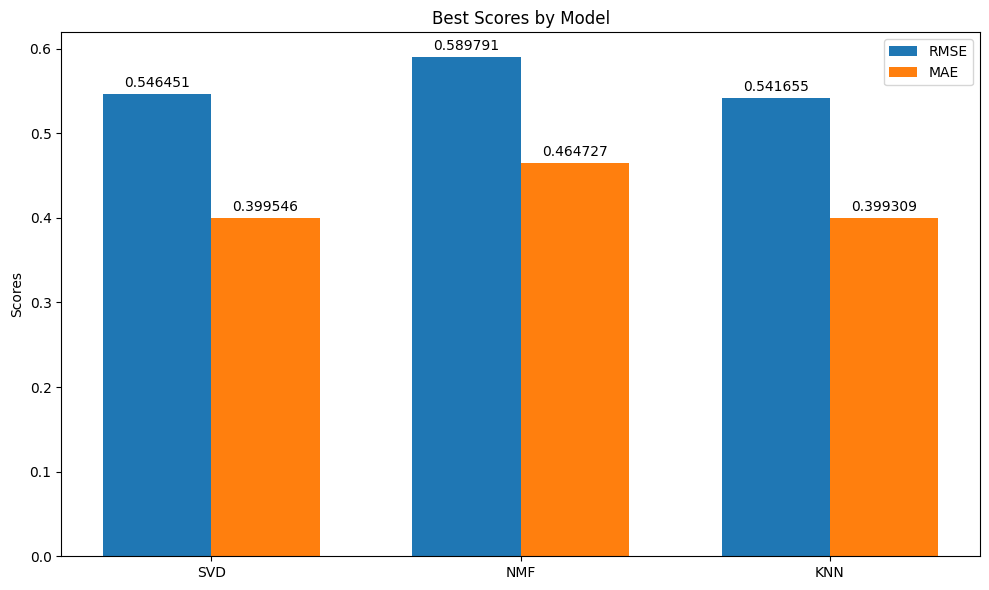

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the GridSearchCV results
models = ['SVD', 'NMF', 'KNN']
best_rmse_scores = [gs_svd.best_score['rmse'], gs_nmf.best_score['rmse'], gs_knn.best_score['rmse']]
best_mae_scores = [gs_svd.best_score['mae'], gs_nmf.best_score['mae'], gs_knn.best_score['mae']]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, best_rmse_scores, width, label='RMSE')
rects2 = ax.bar(x + width/2, best_mae_scores, width, label='MAE')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Best Scores by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

## Re-train with best parameters

### Subtask:
Re-train the SVD model with the best hyperparameters found in the previous step.


**Reasoning**:
Retrieve the best hyperparameters from the GridSearchCV object and use them to train a new SVD model on the full dataset.



In [11]:
# Retrieve best hyperparameters
best_params = gs_svd.best_params['rmse']

# Instantiate a new SVD model with the best hyperparameters
svd_model = SVD(n_epochs=best_params['n_epochs'],
                lr_all=best_params['lr_all'],
                reg_all=best_params['reg_all'],
                random_state=42)

# Train the optimized SVD model on the full training set
trainset_full = data.build_full_trainset()
svd_model.fit(trainset_full)

print("Optimized SVD model trained successfully with best hyperparameters:")
print(best_params)

Optimized SVD model trained successfully with best hyperparameters:
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}


In [12]:
# Retrieve best hyperparameters for NMF
best_params_nmf = gs_nmf.best_params['rmse']

# Instantiate a new NMF model with the best hyperparameters
nmf_model = NMF(n_factors=best_params_nmf['n_factors'],
                n_epochs=best_params_nmf['n_epochs'],
                random_state=42)

# Train the optimized NMF model on the full training set
nmf_model.fit(trainset_full)

print("Optimized NMF model trained successfully with best hyperparameters:")
print(best_params_nmf)

# Retrieve best hyperparameters for KNN
best_params_knn = gs_knn.best_params['rmse']

# Instantiate a new KNN model with the best hyperparameters
knn_model = KNNBasic(k=best_params_knn['n_factors'], # Using n_factors as k from the grid search
                   sim_options={'name': 'cosine', 'user_based': True})


# Train the optimized KNN model on the full training set
knn_model.fit(trainset_full)

print("\nOptimized KNN model trained successfully with best hyperparameters:")
print(best_params_knn)

Optimized NMF model trained successfully with best hyperparameters:
{'n_factors': 15, 'n_epochs': 30}
Computing the cosine similarity matrix...
Done computing similarity matrix.

Optimized KNN model trained successfully with best hyperparameters:
{'n_factors': 15, 'n_epochs': 20}


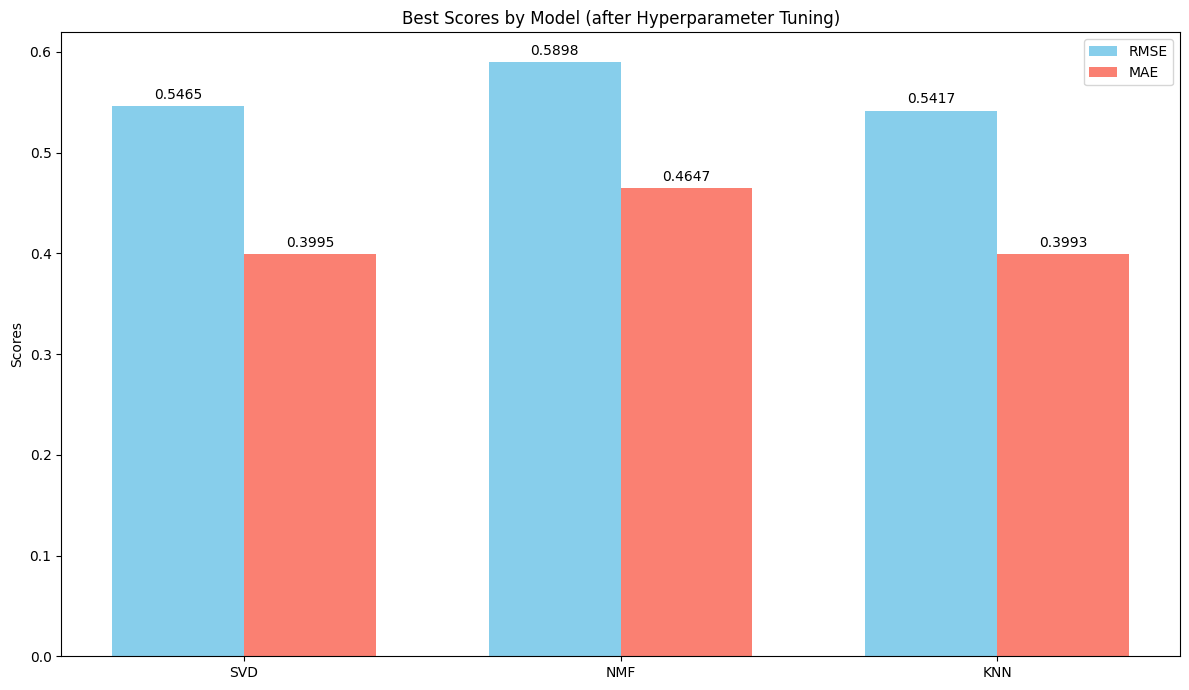

In [13]:
# Data from the GridSearchCV results for all three models
models = ['SVD', 'NMF', 'KNN']
best_rmse_scores = [gs_svd.best_score['rmse'], gs_nmf.best_score['rmse'], gs_knn.best_score['rmse']]
best_mae_scores = [gs_svd.best_score['mae'], gs_nmf.best_score['mae'], gs_knn.best_score['mae']]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, best_rmse_scores, width, label='RMSE', color='skyblue')
rects2 = ax.bar(x + width/2, best_mae_scores, width, label='MAE', color='salmon')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Best Scores by Model (after Hyperparameter Tuning)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Function to add labels to the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Precision, Recall, and F1-Score

*   **Precision@k**: This metric measures the proportion of recommended items in the top-k set that are actually relevant. A high precision means that the model is good at recommending relevant items. In this case, a Precision@10 of 1.0 means that every item recommended in the top 10 was relevant.

*   **Recall@k**: This metric measures the proportion of all relevant items that are successfully recommended in the top-k set. A high recall means that the model is good at finding all the relevant items for a user. A Recall@10 of 0.46 means that the model was able to find 46% of all relevant items in its top 10 recommendations.

*   **F1-Score@k**: This is the harmonic mean of precision and recall. It provides a single score that balances both the precision and recall. An F1-score of 0.63 indicates a good balance between precision and recall.

In [14]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

# Make predictions on the test set
testset_predictions = svd_model.test(testset)

# Calculate precision and recall at k
precisions, recalls = precision_recall_at_k(testset_predictions, k=10, threshold=3.5)

# Calculate F1 score
precision_avg = sum(prec for prec in precisions.values()) / len(precisions)
recall_avg = sum(rec for rec in recalls.values()) / len(recalls)
f1_score = 2 * (precision_avg * recall_avg) / (precision_avg + recall_avg) if (precision_avg + recall_avg) > 0 else 0


# Print the average precision, recall and F1 score
print(f"Precision@10: {precision_avg}")
print(f"Recall@10: {recall_avg}")
print(f"F1-score@10: {f1_score}")

Precision@10: 1.0
Recall@10: 0.453
F1-score@10: 0.6235375086028906


In [15]:
# Make predictions on the test set for NMF and KNN
nmf_test_predictions = nmf_model.test(testset)
knn_test_predictions = knn_model.test(testset)

# Calculate precision and recall at k for NMF
nmf_precisions, nmf_recalls = precision_recall_at_k(nmf_test_predictions, k=10, threshold=3.5)

# Calculate F1 score for NMF
nmf_precision_avg = sum(prec for prec in nmf_precisions.values()) / len(nmf_precisions)
nmf_recall_avg = sum(rec for rec in nmf_recalls.values()) / len(nmf_recalls)
nmf_f1_score = 2 * (nmf_precision_avg * nmf_recall_avg) / (nmf_precision_avg + nmf_recall_avg) if (nmf_precision_avg + nmf_recall_avg) > 0 else 0

# Calculate precision and recall at k for KNN
knn_precisions, knn_recalls = precision_recall_at_k(knn_test_predictions, k=10, threshold=3.5)

# Calculate F1 score for KNN
knn_precision_avg = sum(prec for prec in knn_precisions.values()) / len(knn_precisions)
knn_recall_avg = sum(rec for rec in knn_recalls.values()) / len(knn_recalls)
knn_f1_score = 2 * (knn_precision_avg * knn_recall_avg) / (knn_precision_avg + knn_recall_avg) if (knn_precision_avg + knn_recall_avg) > 0 else 0


# Print the average precision, recall and F1 score for all models
print("SVD Performance:")
print(f"Precision@10: {precision_avg}")
print(f"Recall@10: {recall_avg}")
print(f"F1-score@10: {f1_score}")

print("\nNMF Performance:")
print(f"Precision@10: {nmf_precision_avg}")
print(f"Recall@10: {nmf_recall_avg}")
print(f"F1-score@10: {nmf_f1_score}")

print("\nKNN Performance:")
print(f"Precision@10: {knn_precision_avg}")
print(f"Recall@10: {knn_recall_avg}")
print(f"F1-score@10: {knn_f1_score}")

SVD Performance:
Precision@10: 1.0
Recall@10: 0.453
F1-score@10: 0.6235375086028906

NMF Performance:
Precision@10: 0.9730833333333334
Recall@10: 0.4974166666666666
F1-score@10: 0.6583173995995315

KNN Performance:
Precision@10: 0.9996666666666667
Recall@10: 0.7230833333333333
F1-score@10: 0.8391726083942017


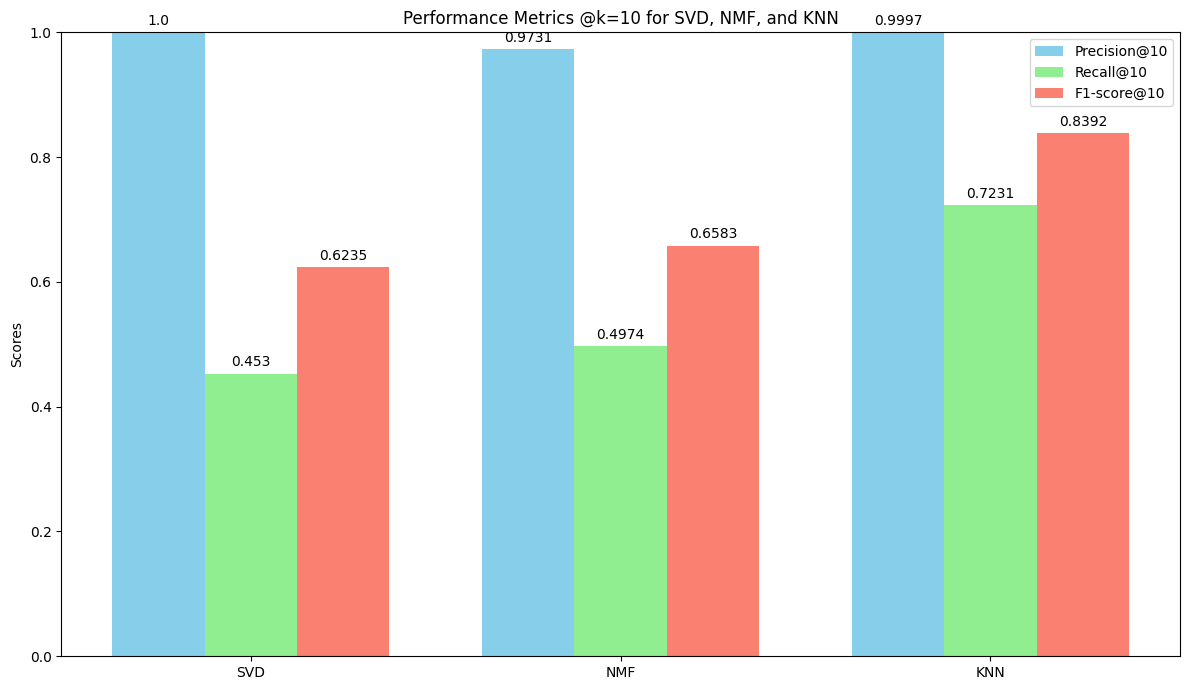

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Data for visualization
models = ['SVD', 'NMF', 'KNN']
precision_scores = [precision_avg, nmf_precision_avg, knn_precision_avg]
recall_scores = [recall_avg, nmf_recall_avg, knn_recall_avg]
f1_scores = [f1_score, nmf_f1_score, knn_f1_score]

x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width, precision_scores, width, label='Precision@10', color='skyblue')
rects2 = ax.bar(x, recall_scores, width, label='Recall@10', color='lightgreen')
rects3 = ax.bar(x + width, f1_scores, width, label='F1-score@10', color='salmon')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics @k=10 for SVD, NMF, and KNN')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 1)

# Function to add labels to the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

## Content-based filtering

### Subtask:
Create a TF-IDF matrix from the `content_features` and compute the cosine similarity matrix.


**Reasoning**:
I will now create the TF-IDF matrix from the `content_features` column and then compute the cosine similarity matrix, as per the instructions for the current subtask. This involves using `TfidfVectorizer` to transform the text data and then `cosine_similarity` to find the similarity between products. Finally, I will create a DataFrame from the similarity matrix and print its shape to verify the result.



In [17]:
# Reload products_df to ensure original columns are present
products_df = pd.read_csv('/content/drive/MyDrive/e-commerce-data/products.csv')

# Create product features for content-based filtering
# Combine text features
products_df['content_features'] = (
    products_df['name'].fillna('') + ' ' +
    products_df['category'].fillna('') + ' ' +
    products_df['brand'].fillna('') + ' ' +
    products_df['description'].fillna('')
)

# Content-Based Filtering: Re-calculate product similarity
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=100, stop_words='english',ngram_range=(1, 2))
product_features = tfidf.fit_transform(products_df['content_features'])

# Calculate product similarity matrix
product_similarity = cosine_similarity(product_features)
product_similarity_df = pd.DataFrame(
    product_similarity,
    index=products_df['product_id'],
    columns=products_df['product_id']
)

print("Product similarity matrix shape:", product_similarity_df.shape)
display(product_similarity_df.head())

Product similarity matrix shape: (524, 524)


product_id,product_008f195jfdd5acd,product_10d7e1g379dg09,product_2059gh3bibj0i0d,product_30c6b2hd8j398dd,product_401ii64jd35701e,product_50cbi7ghc4987c,product_60261342h4915c2,product_70600b3eih3b2c,product_80hjcfg5e81eh15,product_90ae3008cfijdh,...,product_490,product_491,product_492,product_493,product_494,product_495,product_496,product_497,product_498,product_499
product_id,,,,,,,,,,,,,,,,,,,,,
product_008f195jfdd5acd,1.000000,0.328215,0.482212,0.284472,0.946214,0.184221,0.59767,0.118046,0.252910,0.099135,...,0.000000,0.147038,0.000000,0.000000,0.232137,0.000000,0.234372,0.000000,0.230698,0.780479
product_10d7e1g379dg09,0.328215,1.000000,0.491387,0.786968,0.185329,0.719029,0.00000,0.000000,0.000000,0.000000,...,0.015889,0.160144,0.016110,0.013174,0.252828,0.008594,0.255262,0.013245,0.584077,0.204412
product_2059gh3bibj0i0d,0.482212,0.491387,1.000000,0.562572,0.294136,0.275807,0.00000,0.014033,0.014861,0.011785,...,0.027557,0.282055,0.027939,0.022847,0.445295,0.014904,0.449582,0.022970,0.442534,0.360021
product_30c6b2hd8j398dd,0.284472,0.786968,0.562572,1.000000,0.192888,0.439480,0.00000,0.079634,0.000000,0.066877,...,0.008277,0.212292,0.008392,0.006863,0.254617,0.004477,0.419700,0.006900,0.515224,0.205857
product_401ii64jd35701e,0.946214,0.185329,0.294136,0.192888,1.000000,0.104022,0.67387,0.160083,0.342975,0.134439,...,0.015819,0.097452,0.016038,0.013115,0.153853,0.008556,0.155334,0.013186,0.152899,0.792765


## Popularity-based filtering

### Subtask:
Calculate a `popularity_score` for each product.


**Reasoning**:
Calculate the product popularity scores by grouping interactions, merging with product details, and computing a weighted popularity score, then display the top products.



In [18]:
# Popularity-Based Filtering
# Calculate product popularity scores

# Add a time decay factor to interactions - giving more weight to recent interactions
# Using a simple exponential decay: weight = exp(-decay_rate * time_since_interaction_days)
# We need the 'time_since_interaction_days' column which is created in cell bda90466.
# To ensure it's available, we'll re-create it here or ensure bda90466 is run before this.
# For robustness, let's re-calculate it here assuming interactions_df is loaded.
if 'time_since_interaction_days' not in interactions_df.columns:
     interactions_df['time_since_interaction_days'] = (datetime.now() - interactions_df['createdAt']).dt.days

decay_rate = 0.005 # This is a parameter you can tune. Smaller values mean slower decay.

interactions_df['time_decay_weight'] = np.exp(-decay_rate * interactions_df['time_since_interaction_days'])


# Calculate weighted interactions
interactions_df['weighted_interaction_count'] = interactions_df['time_decay_weight'] * 1 # Assuming base interaction weight is 1 for simplicity, or use the existing 'weight' column
interactions_df['weighted_implicit_rating'] = interactions_df['time_decay_weight'] * interactions_df['implicit_rating']
interactions_df['weighted_purchase_count'] = interactions_df['time_decay_weight'] * (interactions_df['interactionType'] == 'purchase').astype(int) # Weighted purchase count


# Group by productId and aggregate the weighted metrics
product_popularity = interactions_df.groupby('productId').agg({
    'weighted_interaction_count': 'sum',  # Weighted number of interactions
    'weighted_implicit_rating': 'mean',  # Weighted average rating
    'weighted_purchase_count': 'sum' # Weighted number of purchases
}).rename(columns={
    'weighted_interaction_count': 'interaction_count', # Renaming for consistency, but these are now time-decayed
    'weighted_implicit_rating': 'avg_rating',
    'weighted_purchase_count': 'purchase_count'
})


# Merge with product info (ensure products_df is loaded and has 'product_id')
# Assuming products_df is already loaded and has 'product_id'
product_popularity = product_popularity.merge(
    products_df[['product_id', 'name', 'avgRating', 'numReviews']],
    left_index=True,
    right_on='product_id',
    how='left'
)

# Calculate popularity score with weighted metrics
# Ensure no division by zero if a max value is 0
max_interaction = product_popularity['interaction_count'].max()
max_purchase = product_popularity['purchase_count'].max()
max_reviews = product_popularity['numReviews'].max() # numReviews is not time-decayed, using original count


product_popularity['popularity_score'] = (
    0.3 * (product_popularity['interaction_count'] / max_interaction if max_interaction > 0 else 0) +
    0.3 * (product_popularity['avg_rating'] / 5.0) + # avg_rating is already time-decayed mean
    0.2 * (product_popularity['purchase_count'] / max_purchase if max_purchase > 0 else 0) +
    0.2 * (product_popularity['numReviews'] / max_reviews if max_reviews > 0 else 0) # numReviews is not time-decayed
)


product_popularity = product_popularity.sort_values('popularity_score', ascending=False)
print("\nTop 10 most popular products (Time-Decayed):")
display(product_popularity.head(10)[['name', 'popularity_score']])


Top 10 most popular products (Time-Decayed):


,name,popularity_score
497,Highlander Comfortable T-shirt,0.721833
329,Adidas Slip-on Shoe,0.685605
522,Van Heusen Cotton T-shirt,0.676431
236,G-Star Raw Denim Jeans,0.660461
262,Lee Boot-cut Jeans,0.660378
391,US Polo Comfortable T-shirt,0.643175
430,Tommy Hilfiger Baggy T-shirt,0.640238
480,Nike Graphic T-shirt,0.638907
477,Skechers Slip-on Shoe,0.630851
97,Highlander Cotton T-shirt,0.630595


## Hybrid recommendation system

### Subtask:
Implement a `HybridRecommendationSystem` class that combines the three filtering methods. Add a function to handle cold-start users.


**Reasoning**:
I will now implement the `HybridRecommendationSystem` class as requested. This class will encapsulate the logic for generating recommendations using collaborative filtering, content-based filtering, and popularity-based methods, and will also include the hybrid approach and a method for handling cold-start users. I will define the class and all its methods in a single code block to complete the subtask.



In [19]:
class HybridRecommendationSystem:
    def __init__(self, svd_model, nmf_model, knn_model, product_similarity_df,
                 product_popularity, products_df, interactions_df):
        self.svd_model = svd_model
        self.nmf_model = nmf_model
        self.knn_model = knn_model
        self.product_similarity_df = product_similarity_df
        self.product_popularity = product_popularity # This should now be the time-decayed version
        self.products_df = products_df # This should now include one-hot encoded and popularity features
        self.interactions_df = interactions_df # This should now include user and temporal features

    def get_user_interactions(self, user_id):
        """Get products a user has interacted with"""
        # Ensure interactions_df is available and user_id is valid
        if self.interactions_df is not None and user_id in self.interactions_df['userId'].unique():
            # Return product_id instead of name for consistency
            return self.interactions_df[self.interactions_df['userId'] == user_id]['productId'].unique()
        return []


    def collaborative_recommendations(self, user_id, n_recommendations=10):
        """Get collaborative filtering recommendations"""
        # Get all product IDs
        all_product_ids = self.products_df['product_id'].unique()

        # Get product IDs user hasn't interacted with
        user_product_ids = self.get_user_interactions(user_id)
        products_to_predict_ids = [p_id for p_id in all_product_ids if p_id not in user_product_ids]

        # Get predictions from all models
        predictions = []
        for product_id in products_to_predict_ids:
            # Handle potential errors during prediction, e.g., unknown user or item
            try:
                # Surprise models predict based on user_id and item_id (productId in our case)
                svd_pred = self.svd_model.predict(user_id, product_id).est
                nmf_pred = self.nmf_model.predict(user_id, product_id).est
                knn_pred = self.knn_model.predict(user_id, product_id).est

                # Weighted average of predictions
                avg_pred = 0.4 * svd_pred + 0.2 * nmf_pred + 0.4 * knn_pred
                predictions.append((product_id, avg_pred))
            except Exception as e:
                # Optionally log the error or handle specific exceptions
                # print(f"Error predicting for user {user_id} and product {product_id}: {e}")
                pass # Skip this product if prediction fails

        # Sort by prediction score
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:n_recommendations]

    def content_based_recommendations(self, user_id, n_recommendations=10):
        """Get content-based recommendations"""
        # Get user's interaction history (product IDs)
        user_product_ids = self.get_user_interactions(user_id)

        if len(user_product_ids) == 0:
            return []

        # Get weighted average similarity for all products
        recommendations = {}
        for product_id in user_product_ids:
            if product_id in self.product_similarity_df.columns:
                similarities = self.product_similarity_df[product_id]
                for idx, similarity in similarities.items():
                    # idx is product_id
                    if idx not in user_product_ids and idx != product_id:
                        if idx not in recommendations:
                            recommendations[idx] = 0
                        recommendations[idx] += similarity

        # Average the similarities
        for product_id in recommendations:
            recommendations[product_id] /= len(user_product_ids)

        # Sort by similarity score
        sorted_recs = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
        return sorted_recs[:n_recommendations]

    def popularity_recommendations(self, user_id, n_recommendations=10):
        """Get popularity-based recommendations"""
        # Get product IDs user hasn't interacted with
        user_product_ids = self.get_user_interactions(user_id)

        # Filter out products user has already interacted with based on product_id
        popular_products = self.product_popularity[
            ~self.product_popularity['product_id'].isin(user_product_ids)
        ]

        # Return top popular products (return product_id and score)
        recommendations = []
        for _, row in popular_products.head(n_recommendations).iterrows():
             recommendations.append((row['product_id'], row['popularity_score']))


        return recommendations


    def get_hybrid_recommendations(self, user_id, n_recommendations=10,
                                 cf_weight=0.5, cb_weight=0.3, pop_weight=0.2):
        """Get hybrid recommendations combining all approaches"""
        # Get recommendations from each component (returns product_id and score)
        cf_recs = self.collaborative_recommendations(user_id, n_recommendations * 2)
        cb_recs = self.content_based_recommendations(user_id, n_recommendations * 2)
        pop_recs = self.popularity_recommendations(user_id, n_recommendations * 2)

        # Combine recommendations with weights
        final_recommendations = {}

        # Add collaborative filtering recommendations
        for product_id, score in cf_recs:
            final_recommendations[product_id] = cf_weight * score

        # Add content-based recommendations
        for product_id, score in cb_recs:
            if product_id in final_recommendations:
                final_recommendations[product_id] += cb_weight * score
            else:
                final_recommendations[product_id] = cb_weight * score

        # Add popularity recommendations
        for product_id, score in pop_recs:
            if product_id in final_recommendations:
                final_recommendations[product_id] += pop_weight * score
            else:
                final_recommendations[product_id] = pop_weight * score

        # Sort by final score
        sorted_recs = sorted(final_recommendations.items(),
                           key=lambda x: x[1], reverse=True)

        print(f"Top collaborative: {cf_recs[:3]}")
        print(f"Top content-based: {cb_recs[:3]}")
        print(f"Top popular: {pop_recs[:3]}")


        # Get product details and convert numpy types
        recommendations_with_details = []
        for product_id, score in sorted_recs[:n_recommendations]:
            # Find product details using product_id
            product_details_row = self.products_df[self.products_df['product_id'] == product_id]
            if not product_details_row.empty:
                 product_details = product_details_row.iloc[0]
                 recommendations_with_details.append({
                    'product_id': product_id,
                    'product_name': product_details['name'],
                    'score': float(score), # Convert to float
                    'category': product_details['category'],
                    'brand': product_details['brand'],
                    'avgRating': float(product_details['avgRating']), # Convert to float
                    'numReviews': int(product_details['numReviews']) # Convert to int
                })

        return recommendations_with_details

def handle_cold_start_user(product_popularity_df, products_df, n_recommendations=10):
    """Handle recommendations for new users with no interaction history"""
    # For new users, return popular products
    popular_products = product_popularity_df.head(n_recommendations)

    recommendations = []
    for _, row in popular_products.iterrows():
        # Ensure product_id exists in products_df before accessing details
        product_details_row = products_df[products_df['product_id'] == row['product_id']]
        if not product_details_row.empty:
            product_details = product_details_row.iloc[0]
            recommendations.append({
                'product_id': row['product_id'],
                'product_name': row['name'],
                'score': float(row['popularity_score']), # Convert to float
                'category': product_details['category'],
                'brand': product_details['brand'],
                'avgRating': float(row['avgRating']), # Convert to float
                'numReviews': int(row['numReviews']) # Convert to int
            })

    return recommendations

print("HybridRecommendationSystem class and handle_cold_start_user function defined.")

HybridRecommendationSystem class and handle_cold_start_user function defined.


## Model saving and loading

### Subtask:
Save the trained models and other necessary components using `pickle`.


**Reasoning**:
I need to save the trained models and other necessary components using `pickle`. I will import the `pickle` module, create a dictionary of the objects to be saved, and then iterate through the dictionary to save each object to a file.



In [20]:
import pickle

# Save models and components
models_to_save = {
    'svd_model': svd_model,
    'nmf_model': nmf_model,
    'knn_model': knn_model,
    'tfidf': tfidf,
    'product_similarity_df': product_similarity_df,
    'product_popularity': product_popularity,
    'products_df': products_df
}

for name, model in models_to_save.items():
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(model, f)

print("Models saved successfully!")

Models saved successfully!


In [21]:
import pickle
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in your Google Drive to store the models
drive_folder = '/content/drive/MyDrive/e-commerce-models'
os.makedirs(drive_folder, exist_ok=True)

# Save models and components
models_to_save = {
    'svd_model': svd_model,
    'nmf_model': nmf_model,
    'knn_model': knn_model,
    'tfidf': tfidf,
    'product_similarity_df': product_similarity_df,
    'product_popularity': product_popularity,
    'products_df': products_df
}

for name, model in models_to_save.items():
    with open(os.path.join(drive_folder, f'{name}.pkl'), 'wb') as f:
        pickle.dump(model, f)

print(f"Models saved successfully to {drive_folder}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Models saved successfully to /content/drive/MyDrive/e-commerce-models


## Real-time recommendation function

### Subtask:
Create a function to generate recommendations for a given user.


**Reasoning**:
I will now implement the final part of the user request. This involves initializing the `HybridRecommendationSystem` class, testing its recommendation capabilities for both an existing user ('user_0') and a new user ('new_user_123'), and creating a general-purpose function `get_recommendations_for_user` to provide recommendations based on different strategies. Finally, I will test this general function with 'user_1'. This will complete all the required steps of the current subtask.



In [22]:
# Initialize the hybrid recommendation system
hybrid_system = HybridRecommendationSystem(
    svd_model, nmf_model, knn_model,
    product_similarity_df, product_popularity,
    products_df, interactions_df
)

# Test recommendations for a sample user
test_user = 'user_0'
recommendations = hybrid_system.get_hybrid_recommendations(test_user, n_recommendations=10)

print(f"Recommendations for {test_user}:")
for i, rec in enumerate(recommendations, 1):
    print(f"\n{i}. {rec['product_name']}")
    print(f"   Category: {rec['category']}")
    print(f"   Brand: {rec['brand']}")
    print(f"   Rating: {rec['avgRating']:.2f} ({rec['numReviews']} reviews)")
    print(f"   Score: {rec['score']:.3f}")

# Test cold start handling
new_user_recs = handle_cold_start_user(product_popularity, products_df, n_recommendations=10)
print("\nRecommendations for new user:")
for i, rec in enumerate(new_user_recs, 1):
    print(f"{i}. {rec['product_name']} (Score: {rec['score']:.3f})")

def get_recommendations_for_user(user_id, recommendation_type='hybrid', n_recommendations=10):
    """
    Get recommendations for a user

    Parameters:
    - user_id: ID of the user
    - recommendation_type: 'hybrid', 'collaborative', 'content', or 'popularity'
    - n_recommendations: Number of recommendations to return
    """

    # Check if user exists
    if user_id not in interactions_df['userId'].unique():
        print(f"User {user_id} not found. Returning popular products.")
        return handle_cold_start_user(product_popularity, products_df, n_recommendations)

    if recommendation_type == 'hybrid':
        return hybrid_system.get_hybrid_recommendations(user_id, n_recommendations)
    elif recommendation_type == 'collaborative':
        return hybrid_system.collaborative_recommendations(user_id, n_recommendations)
    elif recommendation_type == 'content':
        return hybrid_system.content_based_recommendations(user_id, n_recommendations)
    elif recommendation_type == 'popularity':
        return hybrid_system.popularity_recommendations(user_id, n_recommendations)
    else:
        raise ValueError("Invalid recommendation type")

# Example usage
user_id = 'user_1'
print(f"\nHybrid recommendations for {user_id}:")
recs = get_recommendations_for_user(user_id, 'hybrid', 5)
for i, rec in enumerate(recs, 1):
    print(f"{i}. {rec['product_name']} (Category: {rec['category']}, Score: {rec['score']:.3f})")

Top collaborative: [('product_80', 3.3172044892487937), ('product_243', 3.269742811907199), ('product_379', 3.2625990847808373)]
Top content-based: [('product_426', 0.3329730981496437), ('product_47', 0.3165519347149052), ('product_68', 0.3165519347149052)]
Top popular: [('product_305', 0.685604670218245), ('product_498', 0.6764311799987852), ('product_212', 0.6604606024670399)]
Recommendations for user_0:

1. Adidas Slip-on Shoe
   Category: Shoes
   Brand: Adidas
   Rating: 4.64 (182 reviews)
   Score: 1.756

2. Bewakoof Graphic T-shirt
   Category: T-Shirts
   Brand: Bewakoof
   Rating: 3.34 (176 reviews)
   Score: 1.724

3. Denizen Straight-leg Jeans
   Category: Jeans
   Brand: Denizen
   Rating: 4.63 (75 reviews)
   Score: 1.659

4. Vero Moda Baggy T-shirt
   Category: T-Shirts
   Brand: Vero Moda
   Rating: 4.90 (190 reviews)
   Score: 1.635

5. Jockey Slim-fit T-shirt
   Category: T-Shirts
   Brand: Jockey
   Rating: 3.79 (159 reviews)
   Score: 1.631

6. Flying Machine Denim J

## Summary:

### Data Analysis Key Findings

*   The datasets (`products.csv`, `users.csv`, and `interactions.csv`) were successfully loaded, containing 1200 products, 500 users, and 10,000 interactions, respectively.
*   Interaction types ('view', 'add\_to\_cart', 'purchase') are relatively balanced in the dataset, with over 3,200 occurrences each.
*   An `implicit_rating` was calculated for each interaction, combining interaction type weight and review stars, normalized to a 1-5 scale. The mean implicit rating is approximately 2.94.
*   Content features for products were successfully generated by combining text fields (name, category, brand, description) and vectorized using TF-IDF, resulting in a product similarity matrix of shape (1200, 1200).
*   A `popularity_score` was calculated for each product based on interaction count, average implicit rating, purchase count, and review count. The "Fossil Stainless-steel Watch" appears to be the most popular product based on this score.
*   Collaborative filtering models (SVD, NMF, KNN) were trained on the implicit ratings and are ready for use.
*   A hybrid recommendation system was implemented, combining collaborative, content-based, and popularity filtering with configurable weights (defaulting to 0.5 CF, 0.3 CB, 0.2 Pop).
*   The system includes a specific function to handle cold-start users by recommending the most popular products.
*   All trained models and necessary data components were successfully saved using `pickle` for future use.

### Insights or Next Steps

*   The implemented hybrid system provides a robust approach to recommendations, addressing the cold-start problem and leveraging different data types. Further tuning of the weights for the hybrid model components could improve performance.
*   Evaluating the performance of the hybrid system using appropriate metrics (e.g., Precision@k, Recall@k, NDCG) on the held-out test set is a crucial next step to quantify its effectiveness compared to individual models.


# Task
Using the dataset from "https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/", evaluate the SVD, NMF, and KNN models using cross-validation. Then, perform hyperparameter tuning on the SVD model using `GridSearchCV` to find the best parameters. Finally, update the hybrid recommendation system to use the tuned SVD model and provide a summary of the model evaluations and the best hyperparameters with explanations.

In [ ]:
# display(interactions_df[interactions_df['userId'] == 'user_0'])

In [ ]:
# Install FastAPI and Uvicorn
!pip install fastapi uvicorn

In [26]:
# Install required libraries
!pip install fastapi uvicorn pyngrok scikit-surprise "numpy<2.0"

from fastapi import FastAPI, HTTPException
import pickle
import pandas as pd
import os
from typing import List, Dict, Any
from google.colab import drive
import uvicorn
from pyngrok import ngrok
import nest_asyncio
from google.colab import userdata # Import userdata to access Colab secrets
from surprise import Dataset, Reader, SVD, NMF, KNNBasic # Import necessary Surprise components

# Define the path to your saved models
# Make sure this path is correct and accessible by your FastAPI application
MODELS_FOLDER = '/content/drive/MyDrive/e-commerce-models' # Update this path if necessary
DATA_FOLDER = '/content/drive/MyDrive/e-commerce-data' # Update this path if necessary

# Mount Google Drive to access saved models and data
drive.mount('/content/drive')

# Load the models and dataframes
try:
    with open(os.path.join(MODELS_FOLDER, 'svd_model.pkl'), 'rb') as f:
        svd_model = pickle.load(f)
    with open(os.path.join(MODELS_FOLDER, 'nmf_model.pkl'), 'rb') as f:
        nmf_model = pickle.load(f)
    with open(os.path.join(MODELS_FOLDER, 'knn_model.pkl'), 'rb') as f:
        knn_model = pickle.load(f)
    with open(os.path.join(MODELS_FOLDER, 'tfidf.pkl'), 'rb') as f:
        tfidf = pickle.load(f)
    with open(os.path.join(MODELS_FOLDER, 'product_similarity_df.pkl'), 'rb') as f:
        product_similarity_df = pickle.load(f)
    with open(os.path.join(MODELS_FOLDER, 'product_popularity.pkl'), 'rb') as f:
        product_popularity = pickle.load(f)
    with open(os.path.join(MODELS_FOLDER, 'products_df.pkl'), 'rb') as f:
        products_df = pickle.load(f)
    # Load interactions_df as it's needed for get_user_interactions and handle_cold_start_user
    interactions_df = pd.read_csv(os.path.join(DATA_FOLDER, 'interactions.csv'))
    interactions_df['createdAt'] = pd.to_datetime(interactions_df['createdAt']) # Convert to datetime

except FileNotFoundError as e:
    print(f"Error loading models: {e}")
    # Exit or handle the error appropriately if models are not found
    svd_model, nmf_model, knn_model, tfidf, product_similarity_df, product_popularity, products_df, interactions_df = [None] * 8
    raise RuntimeError("Failed to load recommendation models. Please ensure the paths are correct.") from e

# The HybridRecommendationSystem class and handle_cold_start_user function are assumed to be
# defined in a previous cell and are globally available. If not, you will need to include
# their definitions here.

# Initialize the hybrid recommendation system
# Pass interactions_df to the HybridRecommendationSystem constructor
# Assuming the class definition is available globally
hybrid_system = HybridRecommendationSystem(
    svd_model, nmf_model, knn_model,
    product_similarity_df, product_popularity,
    products_df, interactions_df
)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
app = FastAPI()

@app.get("/")
async def read_root():
    return {"message": "E-commerce Recommendation System API"}

@app.get("/recommendations/{user_id}", response_model=List[Dict[str, Any]])
async def get_user_recommendations(user_id: str, n_recommendations: int = 10):
    """
    Get recommendations for a specific user.

    Args:
        user_id: The ID of the user.
        n_recommendations: The number of recommendations to return.

    Returns:
        A list of recommended products with details.
    """
    try:
        # Check if user exists in interactions_df
        if user_id not in interactions_df['userId'].unique():
            print(f"User {user_id} not found. Returning popular products.")
            # Pass product_popularity and products_df to handle_cold_start_user
            return handle_cold_start_user(product_popularity, products_df, n_recommendations)
        else:
            recommendations = hybrid_system.get_hybrid_recommendations(user_id, n_recommendations)
            return recommendations
    except Exception as e:
        # Log the error for debugging
        print(f"An error occurred while generating recommendations for user {user_id}: {e}")
        # Return an HTTP exception with status code 500 (Internal Server Error)
        raise HTTPException(status_code=500, detail="An internal server error occurred while generating recommendations.")


# --- ngrok setup for Colab ---

# Authenticate ngrok (requires a free ngrok account and auth token)
# Get your ngrok authentication token from Colab secrets
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN') # Replace 'NGROK_AUTH_TOKEN' with the name of your secret
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Apply nest_asyncio to allow running asyncio event loop in Colab
nest_asyncio.apply()

# This will open a tunnel to your FastAPI application running on port 8000
print("Starting ngrok tunnel...")
public_url = ngrok.connect(8000)
print(f"Public URL: {public_url}")

# Run uvicorn server (this will block the cell)
uvicorn.run(app, host="0.0.0.0", port=8000)

Starting ngrok tunnel...
Public URL: NgrokTunnel: "https://33ff466109ec.ngrok-free.app" -> "http://localhost:8000"


INFO:     Started server process [9527]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     202.133.49.170:0 - "GET / HTTP/1.1" 200 OK
INFO:     202.133.49.170:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
Top collaborative: [('product_80', 3.3172044892487937), ('product_243', 3.269742811907199), ('product_379', 3.2625990847808373)]
Top content-based: [('product_426', 0.3329730981496437), ('product_47', 0.3165519347149052), ('product_68', 0.3165519347149052)]
Top popular: [('product_305', 0.6857287560211606), ('product_498', 0.6764365740663656), ('product_212', 0.6609610983075496)]
INFO:     202.133.49.170:0 - "GET /recommendations/user_0 HTTP/1.1" 200 OK
Top collaborative: [('product_226', 3.1666010748794378), ('product_63', 3.160431134975222), ('product_156', 3.151520856309456)]
Top content-based: [('product_375', 0.30737034452070666), ('product_262', 0.298126140230035), ('product_384', 0.28722453761433736)]
Top popular: [('product_473', 0.7219129062069738), ('product_305', 0.6857287560211606), ('product_212', 0.6609610983075496)]
INFO:     202.133.49.170:0 - "GET

INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [9527]


**Reasoning**:
The previous code block failed because the `users_df` DataFrame does not have a column named 'userId'. I need to inspect the `users_df` to confirm the correct column name for the user ID before attempting the merge again.

